In [2]:
! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

Cloning into 'MinesweeperLearning'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 320 (delta 145), reused 274 (delta 101), pack-reused 0 (from 0)
Receiving objects: 100% (320/320), 27.95 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (145/145), done.


In [1]:
import os
os.chdir('/content/MinesweeperLearning')

In [2]:
import torch
import numpy as np

import src.utils as utils

from torch.utils.data import DataLoader

from src.models.patch_mlp import MineSweeperDataset, PatchMLPModel, Game
from src.player import Player, ThresholdPlayer

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [4]:
patch_radius = 3
d = 2*patch_radius+1
layers=[2**i for i in range(9, 0, -1)]
name = f'patch_mlp_ordinal_{d}x{d}_{layers[0]}_halving'

model = PatchMLPModel(
    patch_radius,
    layers,
    ordinal_encoding = False,
    mine_rate_channel=True, device=device)
player = ThresholdPlayer(model, 0.05, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

In [5]:
training_size = 50000
train = utils.sample(np.load('data/dataset.npy'), training_size)
test = Game(n = 500)
zeros = test.open_zero()

In [6]:
transform = model.transform
batch_size = 128
training_data = MineSweeperDataset(train, transform)
train_dataloader = DataLoader(training_data, batch_size)

In [7]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(train_dataloader, optimizer)
    player.play(test)
    print(test.win_rate())
    test.reset()
    test.open(zeros)

Epoch 1
-------------------------------
0.0
Epoch 2
-------------------------------
0.0
Epoch 3
-------------------------------
0.01
Epoch 4
-------------------------------
0.014
Epoch 5
-------------------------------
0.028
Epoch 6
-------------------------------
0.026
Epoch 7
-------------------------------
0.042
Epoch 8
-------------------------------
0.054
Epoch 9
-------------------------------
0.048
Epoch 10
-------------------------------
0.068


In [ ]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

In [8]:
g = Game(16, 30, 99, n=1)
_ = g.open_zero()

[ True]
[False]


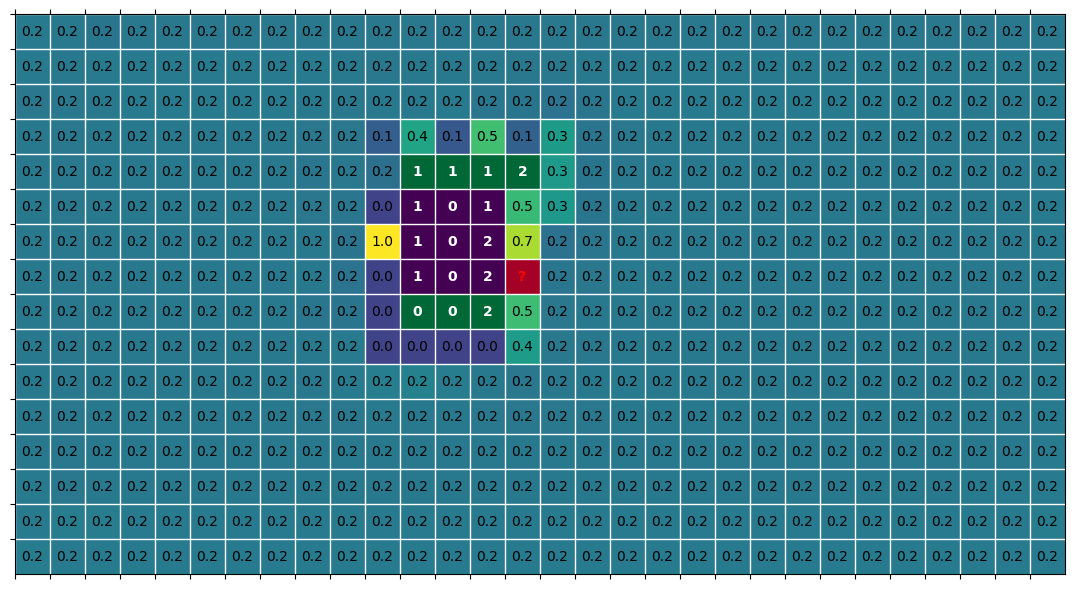

(<Axes: >,
 <matplotlib.image.AxesImage at 0x78652edf56c0>)

In [10]:
o, f = player.step(g)
print(g.active_games)
print(g.won)
p = model(g.game_state(), g.mines_n)
g.pyplot_game(0, mine_probs=p[0], highlighted='last_moves', print_zeros= True, size=0.35) # highlight newly opened in red

In [ ]:
reinforcing_iterations = 10
n = 10000
epochs = 2
for i in range(reinforcing_iterations):
    print(f'iteration {i+1}')
    mines_n = np.random.normal(99, 20, size=n).astype(np.int8)
    games = Game(16, 30, mines_n, n)
    games.random_open(0.3)
    games.random_flags(0.3)
    balanced_play(games, player, 3000, 7)
    print(f'average score: {np.average(games.scores(final_only=True))}')
    print(f'win rate: {games.win_rate()}')
    training_data = MineSweeperDataset(games, transform, mines_weight=1, losing_moves_weight=1)
    train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model.train(train_dataloader, optimizer)
        model.test(test_dataloader)
    model.save(os.path.join('weights', name + '_l2.pth'))
    torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

iteration 1
average score: 0.7122848103415018
win rate: 0.0009260688377836086
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 2
average score: 0.6728132349239694
win rate: 0.038974358974358976
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 3
average score: 0.6928372791728284
win rate: 0.05310734463276836
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 4
average score: 0.7287160145390229
win rate: 0.1098937583001328
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 5
average score: 0.7237185047579601
win rate: 0.11854624863515832
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 6
average score: 0.7194262684029935
win rate: 0.12604392205381998
Epoch 1
-------------------------------
Epoch 2
-------------------------------
iteration 7
average score: 0.7647839070053973
win rate: 0.2175

In [ ]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))